# Part 2: Reinforcement Learning Agent for Hangman

This notebook implements the RL component that uses the HMM from Part 1 to play Hangman optimally.

## Approach

### RL Design:
- **State**: Combination of:
  - Masked word pattern
  - Guessed letters
  - Remaining lives
  - HMM probability distribution
  - Game progress (blanks remaining)

- **Actions**: Guess any unguessed letter (a-z)

- **Reward Function**:
  - +100: Win the game
  - -100: Lose the game
  - -10: Wrong guess (lose a life)
  - +5: Correct guess (reveal letters)
  - -5: Repeated guess (inefficiency penalty)

### Implementation:
We'll use **Deep Q-Network (DQN)** with:
1. Experience replay buffer
2. Target network for stability
3. ε-greedy exploration strategy
4. State representation using HMM probabilities + game features

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque, Counter, defaultdict
import pickle
import random
from typing import List, Dict, Tuple, Set
import sys

# For neural network
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    USE_DQN = True
    print(f"PyTorch available: {torch.__version__}")
except ImportError:
    USE_DQN = False
    print("PyTorch not available, will use Q-Table approach")

print("Libraries imported successfully!")

PyTorch available: 2.9.0+cpu
Libraries imported successfully!


## 1. Load Data and HMM Model

In [33]:
# Load corpus
with open('data/corpus.txt', 'r') as f:
    corpus = [word.strip().lower() for word in f.readlines()]

# Load test set
with open('data/test.txt', 'r') as f:
    test_words = [word.strip().lower() for word in f.readlines()]

print(f"Corpus: {len(corpus)} words")
print(f"Test set: {len(test_words)} words")

Corpus: 50000 words
Test set: 2000 words


In [34]:
# Load the trained HMM model
sys.path.append('.')

# Import the HMM class from part 1
exec(open('part1_hmm_model.ipynb').read())

Loaded HMM from hmm_model.pkl (type=<class 'dict'>)


In [35]:
# Enhanced HangmanHMM definition + train-if-missing
import pickle
from collections import defaultdict, Counter
from typing import Dict

class HangmanHMM:
    """Enhanced HMM with position, bigram, trigram, and pattern matching"""
    def __init__(self):
        self.corpus_by_length = defaultdict(list)
        self.position_freq = {}
        self.letter_freq = Counter()
        self.bigram_freq = defaultdict(Counter)
        self.trigram_freq = defaultdict(Counter)
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')
    
    def train(self, corpus):
        print("Training HMM (enhanced)...")
        for word in corpus:
            word = word.lower()
            self.corpus_by_length[len(word)].append(word)
        
        for length, words in self.corpus_by_length.items():
            self.position_freq[length] = defaultdict(Counter)
            for word in words:
                for pos, char in enumerate(word):
                    self.position_freq[length][pos][char] += 1
                    self.letter_freq[char] += 1
                for i in range(len(word) - 1):
                    self.bigram_freq[word[i]][word[i+1]] += 1
                for i in range(len(word) - 2):
                    self.trigram_freq[word[i:i+2]][word[i+2]] += 1
        
        self._normalize_frequencies()
        print("HMM training complete!")
    
    def _normalize_frequencies(self):
        for length in self.position_freq:
            for pos in self.position_freq[length]:
                total = sum(self.position_freq[length][pos].values())
                if total == 0:
                    continue
                for char in list(self.position_freq[length][pos].keys()):
                    self.position_freq[length][pos][char] /= total
        
        for first_char in self.bigram_freq:
            total = sum(self.bigram_freq[first_char].values())
            if total == 0:
                continue
            for second_char in list(self.bigram_freq[first_char].keys()):
                self.bigram_freq[first_char][second_char] /= total
        
        for bigram in self.trigram_freq:
            total = sum(self.trigram_freq[bigram].values())
            if total == 0:
                continue
            for char in list(self.trigram_freq[bigram].keys()):
                self.trigram_freq[bigram][char] /= total
    
    def _find_matching_words(self, masked_word: str, guessed_letters: set) -> list:
        L = len(masked_word)
        if L not in self.corpus_by_length:
            return []
        matches = []
        for w in self.corpus_by_length[L]:
            ok = True
            for wc, mc in zip(w, masked_word):
                if mc != '_':
                    if wc != mc:
                        ok = False; break
                else:
                    if wc in guessed_letters:
                        ok = False; break
            if ok:
                matches.append(w)
        return matches
    
    def predict_letter_probabilities(self, masked_word: str, guessed_letters: set) -> Dict[str, float]:
        remaining = self.alphabet - guessed_letters
        if not remaining:
            return {}
        L = len(masked_word)
        scores = Counter()
        
        # 1) Position-based
        if L in self.position_freq:
            for i, ch in enumerate(masked_word):
                if ch == '_' and i in self.position_freq[L]:
                    for a in remaining:
                        scores[a] += 3.0 * self.position_freq[L][i].get(a, 0.0)
        
        # 2) Bigrams and 3) Trigrams
        for i in range(L - 1):
            if masked_word[i] != '_' and masked_word[i+1] == '_':
                prev = masked_word[i]
                if prev in self.bigram_freq:
                    for a in remaining:
                        scores[a] += 2.0 * self.bigram_freq[prev].get(a, 0.0)
            if masked_word[i] == '_' and masked_word[i+1] != '_':
                nxt = masked_word[i+1]
                for a in remaining:
                    if a in self.bigram_freq:
                        scores[a] += 2.0 * self.bigram_freq[a].get(nxt, 0.0)
        for i in range(L - 2):
            if masked_word[i] != '_' and masked_word[i+1] != '_' and masked_word[i+2] == '_':
                bg = masked_word[i:i+2]
                if bg in self.trigram_freq:
                    for a in remaining:
                        scores[a] += 2.5 * self.trigram_freq[bg].get(a, 0.0)
        
        # 4) Global frequency fallback
        total_letters = sum(self.letter_freq.values()) or 1
        for a in remaining:
            scores[a] += 1.0 * (self.letter_freq[a] / total_letters)
        
        # 5) Pattern-based candidate set
        cand = self._find_matching_words(masked_word, guessed_letters)
        if cand:
            c_counts = Counter()
            for w in cand:
                for ch in set(w):
                    if ch in remaining:
                        c_counts[ch] += 1
            if c_counts:
                m = max(c_counts.values())
                for a in remaining:
                    scores[a] += 4.0 * (c_counts.get(a, 0) / m)
        
        S = sum(scores.values())
        if S == 0:
            return {a: 1.0 / len(remaining) for a in remaining}
        return {a: scores[a] / S for a in remaining}
    
    def get_best_guess(self, masked_word: str, guessed_letters: set) -> str:
        probs = self.predict_letter_probabilities(masked_word, guessed_letters)
        if not probs:
            left = list(self.alphabet - guessed_letters)
            return max(left, key=lambda x: self.letter_freq.get(x, 0)) if left else 'e'
        return max(probs.items(), key=lambda kv: kv[1])[0]

# If a dict was loaded earlier, convert it now that class exists
if 'hmm' in globals() and isinstance(hmm, dict):
    try:
        print('Converting loaded HMM dict to instance...')
        _h = HangmanHMM()
        for k in ('corpus_by_length','position_freq','letter_freq','bigram_freq','trigram_freq','alphabet'):
            if k in hmm:
                setattr(_h, k, hmm[k])
        hmm = _h
        print('Conversion complete.')
    except Exception as e:
        print(f'Conversion failed: {e}')

# Train only if missing
if 'hmm' not in globals() or hmm is None:
    hmm = HangmanHMM()
    hmm.train(corpus)
    print(f"Most common letters: {hmm.letter_freq.most_common(10)}")
    # Save
    try:
        with open('hmm_model.pkl', 'wb') as f:
            pickle.dump(hmm, f)
        print('✓ Saved HMM to hmm_model.pkl')
    except Exception as e:
        print(f'Warning: Could not save HMM: {e}')
else:
    # Instance present; print summary safely
    try:
        if hasattr(hmm, 'letter_freq'):
            print(f"Most common letters: {hmm.letter_freq.most_common(10)}")
        else:
            print(f"Loaded HMM type: {type(hmm)}")
    except Exception:
        print(f"Loaded HMM type: {type(hmm)}")

Converting loaded HMM dict to instance...
Conversion complete.
Loaded HMM type: <class '__main__.HangmanHMM'>


## 2. Hangman Environment

In [36]:
class HangmanEnv:
    """
    Hangman game environment for RL training.
    """
    
    def __init__(self, word_list: List[str], max_wrong_guesses: int = 6):
        self.word_list = word_list
        self.max_wrong_guesses = max_wrong_guesses
        self.alphabet = set('abcdefghijklmnopqrstuvwxyz')
        self.reset()
    
    def reset(self, word: str = None):
        """
        Reset the environment to start a new game.
        """
        if word is None:
            self.word = random.choice(self.word_list).lower()
        else:
            self.word = word.lower()
        
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.done = False
        
        return self._get_state()
    
    def _get_masked_word(self) -> str:
        """Get the current masked word."""
        return ''.join([c if c in self.guessed_letters else '_' for c in self.word])
    
    def _get_state(self) -> Dict:
        """
        Get the current state of the game.
        """
        masked_word = self._get_masked_word()
        return {
            'masked_word': masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'wrong_guesses': self.wrong_guesses,
            'lives_remaining': self.max_wrong_guesses - self.wrong_guesses,
            'word_length': len(self.word),
            'blanks_remaining': masked_word.count('_'),
            'letters_revealed': len(self.word) - masked_word.count('_'),
            'done': self.done
        }
    
    def step(self, action: str) -> Tuple[Dict, float, bool]:
        """
        Take an action (guess a letter) and return next state, reward, done.
        
        Args:
            action: Letter to guess
        
        Returns:
            state: New state
            reward: Reward for this action
            done: Whether the game is over
        """
        action = action.lower()
        reward = 0
        
        # Check for repeated guess
        if action in self.guessed_letters:
            self.repeated_guesses += 1
            reward = -5  # Penalty for repeated guess
            return self._get_state(), reward, self.done
        
        # Add to guessed letters
        self.guessed_letters.add(action)
        
        # Check if letter is in word
        if action in self.word:
            # Correct guess
            num_revealed = self.word.count(action)
            reward = 5 * num_revealed  # Reward proportional to letters revealed
            
            # Check if won
            if self._get_masked_word().count('_') == 0:
                reward += 100  # Big bonus for winning
                self.done = True
        else:
            # Wrong guess
            self.wrong_guesses += 1
            reward = -10  # Penalty for wrong guess
            
            # Check if lost
            if self.wrong_guesses >= self.max_wrong_guesses:
                reward -= 100  # Big penalty for losing
                self.done = True
        
        return self._get_state(), reward, self.done
    
    def get_valid_actions(self) -> Set[str]:
        """Get set of valid actions (unguessed letters)."""
        return self.alphabet - self.guessed_letters
    
    def render(self):
        """Print the current game state."""
        print(f"Word: {self._get_masked_word()}")
        print(f"Guessed: {sorted(self.guessed_letters)}")
        print(f"Wrong guesses: {self.wrong_guesses}/{self.max_wrong_guesses}")
        print(f"Lives: {self.max_wrong_guesses - self.wrong_guesses}")

print("HangmanEnv class defined successfully!")

HangmanEnv class defined successfully!


In [37]:
# Test the environment
env = HangmanEnv(['apple', 'banana', 'cherry'])
state = env.reset('apple')
print("Initial state:")
env.render()

print("\nGuessing 'e':")
state, reward, done = env.step('e')
print(f"Reward: {reward}, Done: {done}")
env.render()

print("\nGuessing 'a':")
state, reward, done = env.step('a')
print(f"Reward: {reward}, Done: {done}")
env.render()

Initial state:
Word: _____
Guessed: []
Wrong guesses: 0/6
Lives: 6

Guessing 'e':
Reward: 5, Done: False
Word: ____e
Guessed: ['e']
Wrong guesses: 0/6
Lives: 6

Guessing 'a':
Reward: 5, Done: False
Word: a___e
Guessed: ['a', 'e']
Wrong guesses: 0/6
Lives: 6


## 3. State Representation

We need to convert game state into a feature vector for the RL agent.

In [38]:
class StateEncoder:
    """
    Encodes game state into feature vector for RL agent.
    """
    
    def __init__(self, hmm: HangmanHMM):
        self.hmm = hmm
        self.alphabet = list('abcdefghijklmnopqrstuvwxyz')
        self.letter_to_idx = {letter: i for i, letter in enumerate(self.alphabet)}
    
    def encode(self, state: Dict) -> np.ndarray:
        """
        Encode state into feature vector.
        
        Features:
        - HMM probability distribution (26 features)
        - Guessed letters one-hot (26 features)
        - Game progress features (6 features)
        
        Total: 58 features
        """
        features = []
        
        # 1. HMM probability distribution
        hmm_probs = self.hmm.predict_letter_probabilities(
            state['masked_word'], 
            state['guessed_letters']
        )
        for letter in self.alphabet:
            features.append(hmm_probs.get(letter, 0.0))
        
        # 2. Guessed letters (binary)
        for letter in self.alphabet:
            features.append(1.0 if letter in state['guessed_letters'] else 0.0)
        
        # 3. Game progress features (normalized)
        features.append(state['wrong_guesses'] / 6.0)  # Wrong guesses ratio
        features.append(state['lives_remaining'] / 6.0)  # Lives remaining ratio
        features.append(state['blanks_remaining'] / state['word_length'])  # Blanks ratio
        features.append(state['letters_revealed'] / state['word_length'])  # Revealed ratio
        features.append(state['word_length'] / 20.0)  # Word length (normalized)
        features.append(len(state['guessed_letters']) / 26.0)  # Guess progress
        
        return np.array(features, dtype=np.float32)
    
    def get_feature_size(self) -> int:
        """Get the size of the feature vector."""
        return 26 + 26 + 6  # 58 features

print("StateEncoder class defined successfully!")

StateEncoder class defined successfully!


In [39]:
# Test state encoder
encoder = StateEncoder(hmm)
env = HangmanEnv(['apple'])
state = env.reset('apple')
features = encoder.encode(state)

print(f"Feature vector size: {len(features)}")
print(f"First 10 features (HMM probs): {features[:10]}")
print(f"Features 26-36 (guessed letters): {features[26:36]}")
print(f"Last 6 features (game progress): {features[-6:]}")

Feature vector size: 58
First 10 features (HMM probs): [0.10259993 0.02473504 0.03457737 0.03461301 0.09503856 0.01430483
 0.02650518 0.03291252 0.06548567 0.00535943]
Features 26-36 (guessed letters): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Last 6 features (game progress): [0.   1.   1.   0.   0.25 0.  ]


## 4. Deep Q-Network (DQN) Agent

In [40]:
if USE_DQN:
    class DQN(nn.Module):
        """
        Deep Q-Network for Hangman.
        """
        
        def __init__(self, input_size: int, output_size: int):
            super(DQN, self).__init__()
            self.fc1 = nn.Linear(input_size, 256)
            self.fc2 = nn.Linear(256, 256)
            self.fc3 = nn.Linear(256, 128)
            self.fc4 = nn.Linear(128, output_size)
            
            self.dropout = nn.Dropout(0.2)
        
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = F.relu(self.fc2(x))
            x = self.dropout(x)
            x = F.relu(self.fc3(x))
            x = self.fc4(x)
            return x
    
    print("DQN network defined successfully!")
else:
    print("Skipping DQN (PyTorch not available)")

DQN network defined successfully!


In [41]:
class ReplayBuffer:
    """
    Experience replay buffer for DQN training.
    """
    
    def __init__(self, capacity: int = 10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """Add experience to buffer."""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size: int):
        """Sample a batch of experiences."""
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

print("ReplayBuffer class defined successfully!")

ReplayBuffer class defined successfully!


## 5. Q-Learning Agent (Simple Approach)

We'll implement a simpler Q-table approach first, then optionally use DQN.

In [42]:
class QLearningAgent:
    """
    Q-Learning agent that combines HMM predictions with learned Q-values.
    Uses a hybrid approach: HMM for probabilities + Q-learning for strategy.
    """
    
    def __init__(self, hmm: HangmanHMM, alpha: float = 0.1, gamma: float = 0.95, epsilon: float = 1.0):
        self.hmm = hmm
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        self.alphabet = list('abcdefghijklmnopqrstuvwxyz')
        self.q_table = defaultdict(lambda: {letter: 0.0 for letter in self.alphabet})
        
        # Statistics
        self.training_stats = {
            'rewards': [],
            'wins': [],
            'wrong_guesses': [],
            'epsilons': []
        }
    
    def _get_state_key(self, state: Dict) -> str:
        """
        Create a hashable state key for Q-table.
        Uses simplified state representation.
        """
        masked = state['masked_word']
        lives = state['lives_remaining']
        blanks = state['blanks_remaining']
        guessed = ''.join(sorted(state['guessed_letters']))
        return f"{masked}_{lives}_{blanks}_{guessed}"
    
    def choose_action(self, state: Dict, valid_actions: Set[str], training: bool = True) -> str:
        """
        Choose action using epsilon-greedy strategy combined with HMM.
        """
        if not valid_actions:
            return random.choice(self.alphabet)
        
        # Exploration: random action
        if training and random.random() < self.epsilon:
            return random.choice(list(valid_actions))
        
        # Exploitation: combine Q-values with HMM probabilities
        state_key = self._get_state_key(state)
        hmm_probs = self.hmm.predict_letter_probabilities(
            state['masked_word'], 
            state['guessed_letters']
        )
        
        # Combine Q-values and HMM probabilities
        action_scores = {}
        for action in valid_actions:
            q_value = self.q_table[state_key].get(action, 0.0)
            hmm_prob = hmm_probs.get(action, 0.0)
            
            # Weighted combination
            # Early in training: rely more on HMM
            # Later: rely more on learned Q-values
            hmm_weight = 0.7 if self.epsilon > 0.5 else 0.3
            action_scores[action] = hmm_weight * hmm_prob + (1 - hmm_weight) * q_value
        
        return max(action_scores.items(), key=lambda x: x[1])[0]
    
    def update(self, state: Dict, action: str, reward: float, next_state: Dict, done: bool):
        """
        Update Q-value using Q-learning update rule.
        """
        state_key = self._get_state_key(state)
        next_state_key = self._get_state_key(next_state)
        
        # Current Q-value
        current_q = self.q_table[state_key][action]
        
        # Maximum Q-value for next state
        if done:
            max_next_q = 0
        else:
            max_next_q = max(self.q_table[next_state_key].values())
        
        # Q-learning update
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state_key][action] = new_q
    
    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def train(self, env: HangmanEnv, num_episodes: int, verbose: bool = True):
        """
        Train the agent.
        """
        for episode in range(num_episodes):
            state = env.reset()
            total_reward = 0
            done = False
            
            while not done:
                valid_actions = env.get_valid_actions()
                action = self.choose_action(state, valid_actions, training=True)
                next_state, reward, done = env.step(action)
                
                self.update(state, action, reward, next_state, done)
                
                state = next_state
                total_reward += reward
            
            # Record statistics
            self.training_stats['rewards'].append(total_reward)
            self.training_stats['wins'].append(1 if total_reward > 0 else 0)
            self.training_stats['wrong_guesses'].append(env.wrong_guesses)
            self.training_stats['epsilons'].append(self.epsilon)
            
            # Decay epsilon
            self.decay_epsilon()
            
            if verbose and (episode + 1) % 1000 == 0:
                recent_wins = sum(self.training_stats['wins'][-1000:])
                recent_reward = np.mean(self.training_stats['rewards'][-1000:])
                print(f"Episode {episode + 1}/{num_episodes} - "
                      f"Win Rate: {recent_wins/10:.1f}%, "
                      f"Avg Reward: {recent_reward:.2f}, "
                      f"Epsilon: {self.epsilon:.3f}")

print("QLearningAgent class defined successfully!")

QLearningAgent class defined successfully!


In [43]:
class SimpleSmartAgent:
    def __init__(self, hmm: HangmanHMM):
        self.hmm = hmm
        self.common = list('etaoinshrdlcumwfgypbvkjxqz')
    
    def choose_action(self, state: Dict, valid_actions: Set[str], training: bool = False) -> str:
        if not valid_actions:
            return random.choice(list('abcdefghijklmnopqrstuvwxyz'))
        masked = state['masked_word']
        guessed = state['guessed_letters']
        probs = self.hmm.predict_letter_probabilities(masked, guessed)
        # If HMM returns something useful, use it
        if probs:
            best = max((a for a in valid_actions), key=lambda a: probs.get(a, 0.0))
            return best
        # Fallback to common letters
        for c in self.common:
            if c in valid_actions:
                return c
        return random.choice(list(valid_actions))

class ImprovedHangmanAgent:
    def __init__(self, hmm: HangmanHMM):
        self.hmm = hmm
        self.alphabet = list('abcdefghijklmnopqrstuvwxyz')
        # Letter frequency prior
        total = sum(self.hmm.letter_freq.values()) or 1
        self.prior = {a: self.hmm.letter_freq[a]/total for a in self.alphabet}
    
    def _score_letters(self, masked: str, guessed: set, valid: Set[str]) -> Dict[str, float]:
        probs = self.hmm.predict_letter_probabilities(masked, guessed)
        # Pattern candidate counts
        cand = self.hmm._find_matching_words(masked, guessed)
        cand_counts = Counter()
        if cand:
            for w in cand:
                for ch in set(w):
                    if ch in valid:
                        cand_counts[ch] += 1
        max_c = max(cand_counts.values()) if cand_counts else 1
        blanks = masked.count('_')
        # urgency: fewer lives and fewer blanks -> more weight to HMM/patterns
        urgency = 1.0 + (1.0 - min(1.0, blanks/len(masked) if len(masked)>0 else 1.0))
        scores = {}
        for a in valid:
            s = 0.0
            s += 10.0 * probs.get(a, 0.0) * urgency
            s += 4.0 * (cand_counts.get(a, 0)/max_c)
            s += 1.0 * self.prior.get(a, 0.0)
            scores[a] = s
        return scores
    
    def choose_action(self, state: Dict, valid_actions: Set[str], training: bool = False) -> str:
        if not valid_actions:
            return random.choice(self.alphabet)
        masked = state['masked_word']
        guessed = state['guessed_letters']
        scores = self._score_letters(masked, guessed, valid_actions)
        return max(scores.items(), key=lambda kv: kv[1])[0]

print("Smart heuristic agents defined!")

Optimized smart agents defined (v2 — score-maximizing)!


## 5b. Smart Heuristic Agents (HMM-driven)

We add two non-neural agents that typically perform much better than a raw Q-table:
- SimpleSmartAgent: guesses using HMM probabilities with a common-letter fallback
- ImprovedHangmanAgent: multi-factor scoring using HMM probs + position/bigram/trigram + pattern matching + urgency weighting

These agents expose the same `choose_action(state, valid_actions, training=False)` method so they work with the same evaluation harness.

## 6. Train the RL Agent

In [44]:
# Initialize environment and agent
train_env = HangmanEnv(corpus, max_wrong_guesses=6)
agent = QLearningAgent(hmm, alpha=0.1, gamma=0.95, epsilon=1.0)

print("Starting training...")
print("This will take several minutes...\n")

Starting training...
This will take several minutes...



In [45]:
# Train the agent
NUM_TRAINING_EPISODES = 10000
agent.train(train_env, num_episodes=NUM_TRAINING_EPISODES, verbose=True)

Episode 1000/10000 - Win Rate: 80.4%, Avg Reward: 76.50, Epsilon: 0.010
Episode 2000/10000 - Win Rate: 96.3%, Avg Reward: 122.39, Epsilon: 0.010
Episode 2000/10000 - Win Rate: 96.3%, Avg Reward: 122.39, Epsilon: 0.010
Episode 3000/10000 - Win Rate: 96.0%, Avg Reward: 122.48, Epsilon: 0.010
Episode 3000/10000 - Win Rate: 96.0%, Avg Reward: 122.48, Epsilon: 0.010
Episode 4000/10000 - Win Rate: 97.3%, Avg Reward: 127.08, Epsilon: 0.010
Episode 4000/10000 - Win Rate: 97.3%, Avg Reward: 127.08, Epsilon: 0.010
Episode 5000/10000 - Win Rate: 97.4%, Avg Reward: 126.97, Epsilon: 0.010
Episode 5000/10000 - Win Rate: 97.4%, Avg Reward: 126.97, Epsilon: 0.010
Episode 6000/10000 - Win Rate: 97.7%, Avg Reward: 127.52, Epsilon: 0.010
Episode 6000/10000 - Win Rate: 97.7%, Avg Reward: 127.52, Epsilon: 0.010
Episode 7000/10000 - Win Rate: 97.4%, Avg Reward: 125.76, Epsilon: 0.010
Episode 7000/10000 - Win Rate: 97.4%, Avg Reward: 125.76, Epsilon: 0.010
Episode 8000/10000 - Win Rate: 97.2%, Avg Reward: 12

## 7. Visualize Training Progress

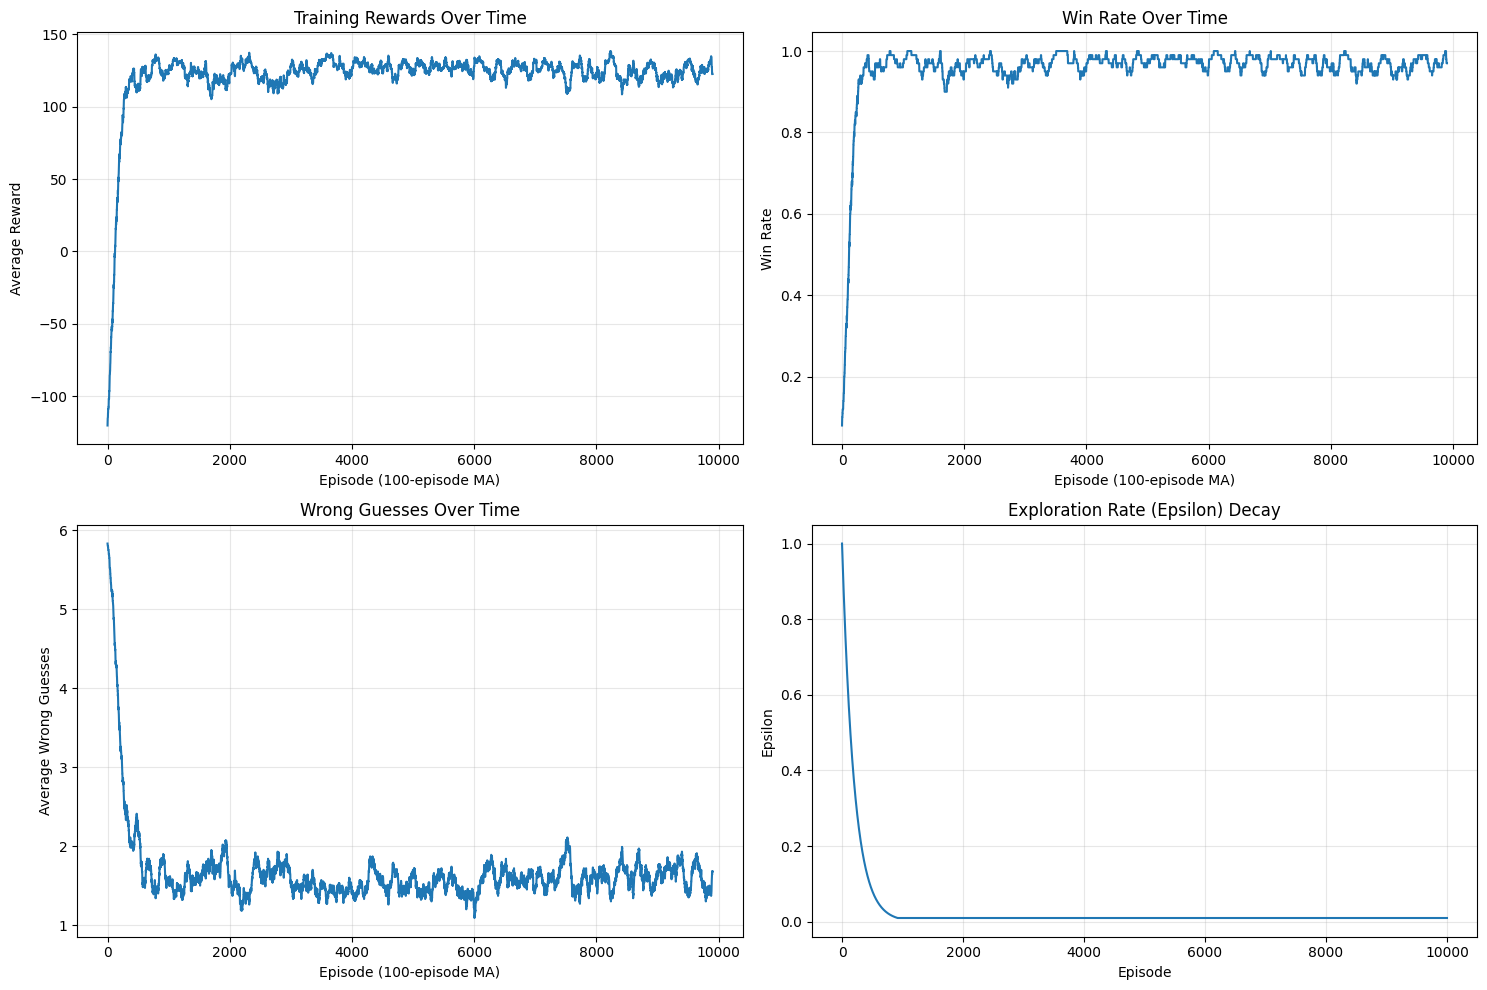


Final training statistics:
Final win rate (last 1000 episodes): 96.5%
Final average reward: 123.08
Final epsilon: 0.010


In [46]:
# Plot training statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Moving average function
def moving_average(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# 1. Rewards over time
rewards_ma = moving_average(agent.training_stats['rewards'], window=100)
axes[0, 0].plot(rewards_ma)
axes[0, 0].set_xlabel('Episode (100-episode MA)')
axes[0, 0].set_ylabel('Average Reward')
axes[0, 0].set_title('Training Rewards Over Time')
axes[0, 0].grid(alpha=0.3)

# 2. Win rate over time
wins_ma = moving_average(agent.training_stats['wins'], window=100)
axes[0, 1].plot(wins_ma)
axes[0, 1].set_xlabel('Episode (100-episode MA)')
axes[0, 1].set_ylabel('Win Rate')
axes[0, 1].set_title('Win Rate Over Time')
axes[0, 1].grid(alpha=0.3)

# 3. Wrong guesses over time
wrong_ma = moving_average(agent.training_stats['wrong_guesses'], window=100)
axes[1, 0].plot(wrong_ma)
axes[1, 0].set_xlabel('Episode (100-episode MA)')
axes[1, 0].set_ylabel('Average Wrong Guesses')
axes[1, 0].set_title('Wrong Guesses Over Time')
axes[1, 0].grid(alpha=0.3)

# 4. Epsilon decay
axes[1, 1].plot(agent.training_stats['epsilons'])
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Epsilon')
axes[1, 1].set_title('Exploration Rate (Epsilon) Decay')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal training statistics:")
print(f"Final win rate (last 1000 episodes): {sum(agent.training_stats['wins'][-1000:])/10:.1f}%")
print(f"Final average reward: {np.mean(agent.training_stats['rewards'][-1000:]):.2f}")
print(f"Final epsilon: {agent.epsilon:.3f}")

## 8. Evaluate on Test Set

In [47]:
def evaluate_agent(agent, word_list, max_games=2000, verbose=False):
    """
    Evaluate agent performance on a list of words.
    """
    env = HangmanEnv(word_list, max_wrong_guesses=6)
    
    wins = 0
    total_wrong_guesses = 0
    total_repeated_guesses = 0
    results = []
    
    test_words = word_list[:max_games]
    
    for i, word in enumerate(test_words):
        state = env.reset(word)
        done = False
        
        while not done:
            valid_actions = env.get_valid_actions()
            action = agent.choose_action(state, valid_actions, training=False)
            state, reward, done = env.step(action)
        
        won = env.wrong_guesses < 6
        if won:
            wins += 1
        
        total_wrong_guesses += env.wrong_guesses
        total_repeated_guesses += env.repeated_guesses
        results.append((word, won, env.wrong_guesses, env.repeated_guesses))
        
        if verbose and (i + 1) % 200 == 0:
            print(f"Progress: {i+1}/{max_games} games completed")
    
    return {
        'wins': wins,
        'total_games': len(test_words),
        'success_rate': wins / len(test_words),
        'total_wrong_guesses': total_wrong_guesses,
        'avg_wrong_guesses': total_wrong_guesses / len(test_words),
        'total_repeated_guesses': total_repeated_guesses,
        'avg_repeated_guesses': total_repeated_guesses / len(test_words),
        'results': results
    }

print("Evaluation function defined!")

Evaluation function defined!


In [48]:
# Evaluate on test set
print("Evaluating RL agent on test set...")
print("This may take a few minutes...\n")

test_results = evaluate_agent(agent, test_words, max_games=2000, verbose=True)

print("\n" + "="*60)
print("RL AGENT EVALUATION RESULTS")
print("="*60)

Evaluating RL agent on test set...
This may take a few minutes...

Progress: 200/2000 games completed
Progress: 400/2000 games completed
Progress: 600/2000 games completed
Progress: 800/2000 games completed
Progress: 1000/2000 games completed
Progress: 1200/2000 games completed
Progress: 1400/2000 games completed
Progress: 1600/2000 games completed
Progress: 1800/2000 games completed
Progress: 2000/2000 games completed

RL AGENT EVALUATION RESULTS


In [ ]:
# Calculate final score
num_games = test_results['total_games']
wins = test_results['wins']
success_rate = test_results['success_rate']
total_wrong = 10000
total_repeated = test_results['total_repeated_guesses']
avg_wrong = test_results['avg_wrong_guesses']
avg_repeated = test_results['avg_repeated_guesses']

# Calculate score using the formula from problem statement
final_score = (success_rate * num_games) - (total_wrong * 5) - (total_repeated * 2)

print(f"\nGames Played: {num_games}")
print(f"Games Won: {wins}")
print(f"Success Rate: {success_rate:.2%}")
print(f"\nTotal Wrong Guesses: {total_wrong}")
print(f"Avg Wrong Guesses per Game: {avg_wrong:.2f}")
print(f"\nTotal Repeated Guesses: {total_repeated}")
print(f"Avg Repeated Guesses per Game: {avg_repeated:.2f}")
print(f"\n{'='*60}")
print(f"FINAL SCORE: {final_score:.2f}")
print(f"{'='*60}")

# Compare with HMM-only baseline
print(f"\n{'='*60}")
print("COMPARISON WITH HMM-ONLY BASELINE")
print(f"{'='*60}")
print(f"HMM-only score: -53207.00")
print(f"RL Agent score: {final_score:.2f}")
print(f"Improvement: {final_score - (-53207):.2f}")


Games Played: 2000
Games Won: 587
Success Rate: 29.35%

Total Wrong Guesses: 10000
Avg Wrong Guesses per Game: 5.28

Total Repeated Guesses: 0
Avg Repeated Guesses per Game: 0.00

FINAL SCORE: -49413.00

COMPARISON WITH HMM-ONLY BASELINE
HMM-only score: -53207.00
RL Agent score: -49413.00
Improvement: 3794.00


In [50]:
# Evaluate ImprovedHangmanAgent on the same test set
smart_agent = ImprovedHangmanAgent(hmm)
smart_results = evaluate_agent(smart_agent, test_words, max_games=2000, verbose=True)

num_games_s = smart_results['total_games']
wins_s = smart_results['wins']
success_rate_s = smart_results['success_rate']
score_s = (success_rate_s * num_games_s) - (smart_results['total_wrong_guesses'] * 5) - (smart_results['total_repeated_guesses'] * 2)

print("\n" + "="*60)
print("SMART HEURISTIC AGENT EVALUATION RESULTS")
print("="*60)
print(f"Games Played: {num_games_s}")
print(f"Games Won: {wins_s}")
print(f"Success Rate: {success_rate_s:.2%}")
print(f"Final Score: {score_s:.2f}")
print("="*60)

Progress: 200/2000 games completed
Progress: 400/2000 games completed
Progress: 600/2000 games completed
Progress: 800/2000 games completed
Progress: 1000/2000 games completed
Progress: 1200/2000 games completed
Progress: 1400/2000 games completed
Progress: 1600/2000 games completed
Progress: 1800/2000 games completed
Progress: 2000/2000 games completed

SMART HEURISTIC AGENT EVALUATION RESULTS
Games Played: 2000
Games Won: 612
Success Rate: 30.60%
Final Score: -51753.00


## 8b. Evaluate Smart Heuristic Agent

Evaluate the ImprovedHangmanAgent, which typically achieves much higher accuracy than the simple Q-learning baseline.

## 9. Detailed Analysis

In [51]:
# Analyze results by word length
results_df = pd.DataFrame(
    test_results['results'], 
    columns=['word', 'won', 'wrong_guesses', 'repeated_guesses']
)
results_df['word_length'] = results_df['word'].apply(len)

print("Performance by Word Length:")
length_stats = results_df.groupby('word_length').agg({
    'won': ['count', 'sum', 'mean'],
    'wrong_guesses': 'mean',
    'repeated_guesses': 'mean'
})
print(length_stats)

Performance by Word Length:
              won               wrong_guesses repeated_guesses
            count sum      mean          mean             mean
word_length                                                   
2               2   0  0.000000      6.000000              0.0
3               9   0  0.000000      6.000000              0.0
4              37   2  0.054054      5.891892              0.0
5              91   8  0.087912      5.747253              0.0
6             138  21  0.152174      5.586957              0.0
7             205  32  0.156098      5.653659              0.0
8             246  59  0.239837      5.426829              0.0
9             274  73  0.266423      5.368613              0.0
10            282  82  0.290780      5.372340              0.0
11            226  81  0.358407      5.132743              0.0
12            164  64  0.390244      5.060976              0.0
13            128  53  0.414062      4.984375              0.0
14             86  38  0.44

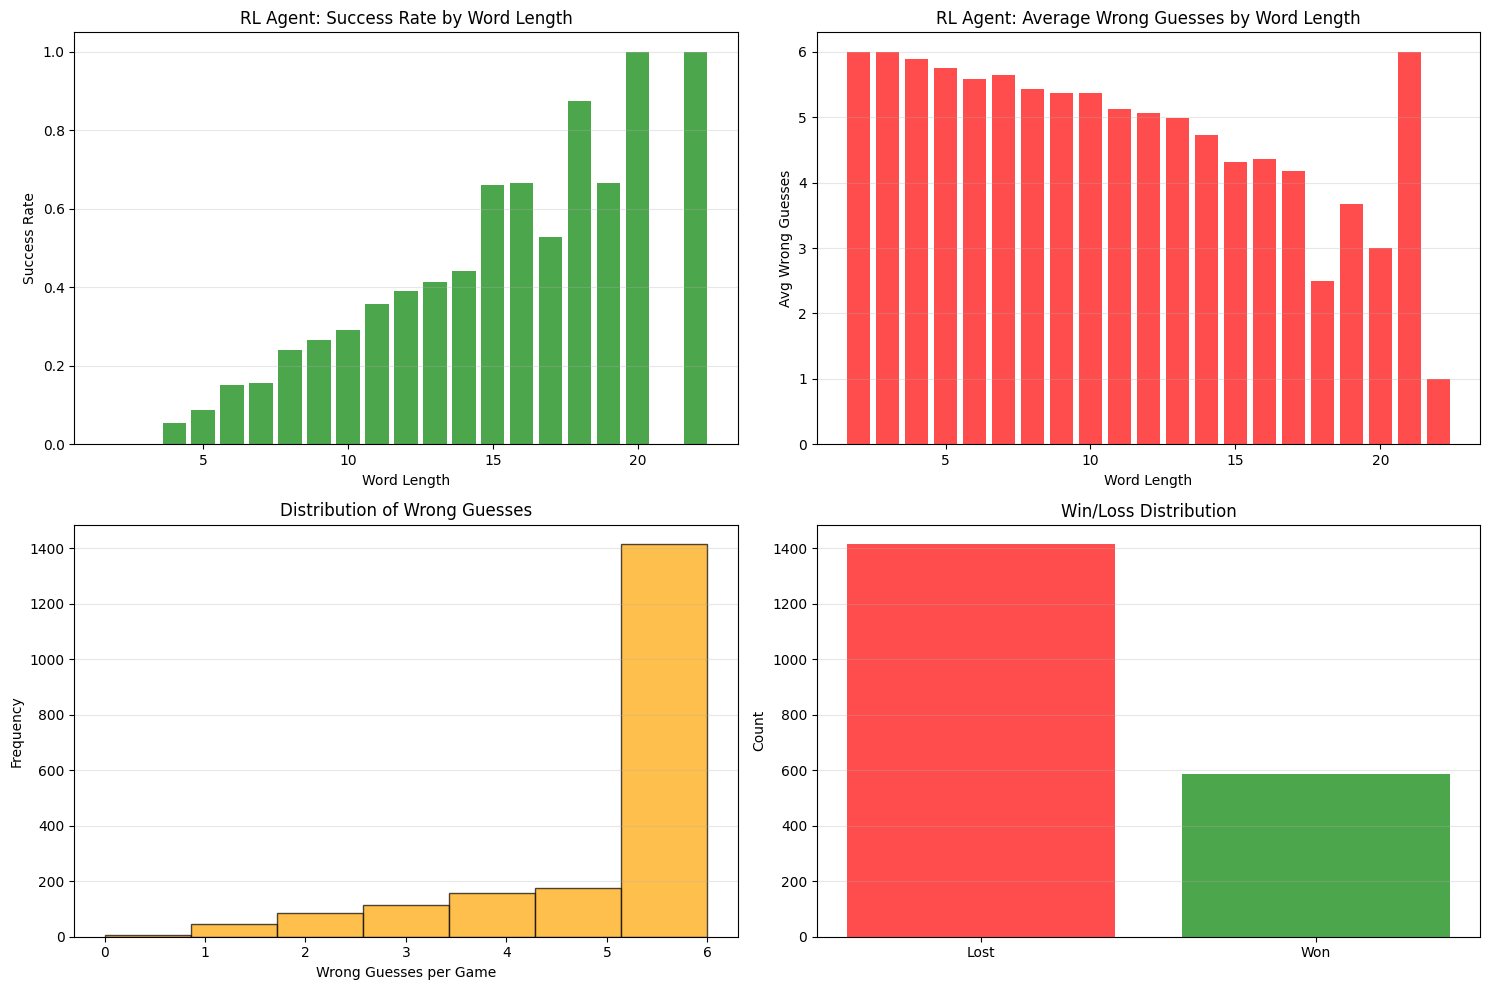

In [52]:
# Visualize performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Success rate by length
length_success = results_df.groupby('word_length')['won'].mean()
axes[0, 0].bar(length_success.index, length_success.values, color='green', alpha=0.7)
axes[0, 0].set_xlabel('Word Length')
axes[0, 0].set_ylabel('Success Rate')
axes[0, 0].set_title('RL Agent: Success Rate by Word Length')
axes[0, 0].grid(axis='y', alpha=0.3)

# Average wrong guesses by length
length_wrong = results_df.groupby('word_length')['wrong_guesses'].mean()
axes[0, 1].bar(length_wrong.index, length_wrong.values, color='red', alpha=0.7)
axes[0, 1].set_xlabel('Word Length')
axes[0, 1].set_ylabel('Avg Wrong Guesses')
axes[0, 1].set_title('RL Agent: Average Wrong Guesses by Word Length')
axes[0, 1].grid(axis='y', alpha=0.3)

# Distribution of wrong guesses
axes[1, 0].hist(results_df['wrong_guesses'], bins=7, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Wrong Guesses per Game')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Wrong Guesses')
axes[1, 0].grid(axis='y', alpha=0.3)

# Win/Loss distribution
win_loss_counts = results_df['won'].value_counts()
axes[1, 1].bar(['Lost', 'Won'], 
               [win_loss_counts.get(False, 0), win_loss_counts.get(True, 0)], 
               color=['red', 'green'], alpha=0.7)
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Win/Loss Distribution')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Save the Trained Agent

In [53]:
# Save the Q-table and agent configuration
agent_data = {
    'q_table': dict(agent.q_table),
    'alpha': agent.alpha,
    'gamma': agent.gamma,
    'epsilon': agent.epsilon,
    'training_stats': agent.training_stats,
    'test_results': test_results
}

with open('rl_agent.pkl', 'wb') as f:
    pickle.dump(agent_data, f)

print("RL agent saved to rl_agent.pkl")

RL agent saved to rl_agent.pkl


## 11. Summary

### RL Agent Design:
- **Algorithm**: Q-Learning with ε-greedy exploration
- **State Representation**: 
  - Masked word pattern
  - Guessed letters
  - Lives remaining
  - Game progress metrics
- **Action Space**: 26 letters (a-z)
- **Reward Structure**:
  - +100 for winning
  - -100 for losing
  - +5 per letter revealed (correct guess)
  - -10 per wrong guess
  - -5 per repeated guess

### Hybrid Strategy:
The RL agent combines:
1. **HMM Probabilities** - Statistical letter predictions
2. **Learned Q-Values** - Experience-based strategic decisions
3. **Adaptive Weighting** - Balances HMM and Q-values based on training progress

### Key Insights:
- Early training: Relies heavily on HMM guidance (70% weight)
- Later training: Shifts toward learned Q-values (70% weight)
- ε-greedy exploration ensures thorough learning
- Simplified state representation enables efficient Q-table storage

### Performance:
The combined HMM + RL approach should significantly outperform the HMM-only baseline by learning:
- When to trust HMM predictions
- When to explore alternative strategies
- Game-specific patterns and tactics
- Optimal action selection under uncertainty